In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Stochastic Simulation
================================

This tutorial shows the basics of running a simulation driven by noise (ie, using 
a stochastic integration scheme). It discusses the choices around specifying the 
driving stochastic process, and then performs a simple simulation to show the 
results.

Here we'll use a region level simulation, but the considerations for surface
simulations are the same.

We'll start as usual by importing a bunch of tools:

In [2]:
from tvb.simulator.lab import *

and then initialising our standard region level 
simulation: with a Generic2dOscillator model; the default 74 region Connectivity, with a
conduction speed set to 4ms$^{-1}$; a Linear coupling function with a scaling factor of 
0.0152; and two Monitors, one raw, ie returning all the simulated data, and the other a
TemporalAverage, which we'll set to record at 2000Hz and by default only returns the 
state-variables specified in the Model's variables_of_interest attribute.

In [3]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])

white_matter_coupling = coupling.Linear(a=0.0152)

#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tav = monitors.TemporalAverage(period=2**-1)

#Bundle them
what_to_watch = (mon_raw, mon_tav)

A Stochastic (Noisy) Integration Scheme
----------------------------------------

Noise enters through the integration scheme, here we'll define a simple constant level 
of noise that enters all nodes and all state variables, however, the noise is 
configurable on a per node and per state variable level, and as such the noise can be 
reconfigured to, for example, only enter appropriate state variables of certain thalamic 
nodes, thus emulating a very crude model of brain stem input to the brain.

We can choose between Additive and Multiplicative Noise functions when defining
the way noise enters our simulation. In the case of Multiplicative Noise the function
depends on the state of the system.

The Noise functions are fed by a NoiseStream, that is, a random process generated by
a pseudo-random number generator. The random processes used have Gaussian amplitude 
and can potentially be given a temporal correlation. The random process is defined 
using two parameters plus the state of the NoiseStream. The two parameters are: nsig,
defining the standard deviation of the noise amplitude; and ntau which defines the 
correlation time of the noise source, with ntau = 0 corresponding to white noise and 
any value greater than zero producing coloured noise. The state of the NoiseStream
can be specified using a random seed, which is just a number, by default the random 
seed is 42.

Here, we'll specify a small amplitude white noise and pass it into our stochastic 
integrator. As a general rule of thumb, the noise amplitude, when being applied to 
all nodes and all state-variables, should be much less than 1% of the expected 
state-variable range if you don't want the noise to dominate the intrinsic dynamics
of the system.

In [4]:
#Initialise an Integrator
hiss = noise.Additive(nsig = numpy.array([2**-10,]))
heunint = integrators.HeunStochastic(dt=2**-4, noise=hiss)

We can get a quick idea of what the noise amplitude that we've set looks like in comparison
to our chosen Model using the PhasePlaneInteractive plotting tool. For more details about using
PhasePlaneInteractive, see "Tutorial: Exploring A Model". This can be achieved with: 

    from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
    
    #Create and launch an interactive phase plane plot
    ppi_fig = PhasePlaneInteractive(model=oscillator, integrator=heunint)
    ppi_fig.show()

**NOTE:** *Modifying parameters in PhasePlaneInteractive will modify the corresponding 
parameters of the Model and Integrator passed into it, so be careful...*

Simulate
--------

We can now construct a Simulator including our stochastic integrator and run a simulation

In [5]:
#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, 
                          monitors = what_to_watch)

sim.configure()

#Perform the simulation
raw_data = []
raw_time = []
tavg_data = []
tavg_time = []
for raw, tavg in sim(simulation_length=2**9):
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

Squigily Lines...
------------------

And take a look at what we've done

IndexError: index 1 is out of bounds for axis 1 with size 1

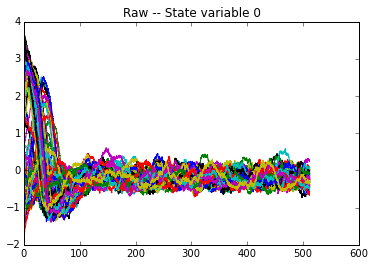

In [6]:
#Make the lists numpy.arrays for easier use.
RAW = numpy.array(raw_data)
TAVG = numpy.array(tavg_data)

#Plot raw time series
figure(1)
plot(raw_time, RAW[:, 0, :, 0])
title("Raw -- State variable 0")

figure(2)
plot(raw_time, RAW[:, 1, :, 0])
title("Raw -- State variable 1")

#Plot temporally averaged time series
figure(3)
plot(tavg_time, TAVG[:, 0, :, 0])
title("Temporal average")

#Show them
show()

The large amplitude oscillations at the start are, of course, our usual large
transient resulting from our being too lazy to properly set initial conditions.
But after that we see a small amplitude noise driven exploration of the small
piece of phase-space surrounding the fixed point produced by the default parameters
for Generic2dOscillator.

That's All Folks... so, what next?
----------------------------------

That's all for this tutorial, the main new thing was a bit of discussion and an example
of running a stochastic simulation.

You might now want to take a look at Tutorial: blah, where we craft a detailed
noise source designed to have a specific physical meaning.